In [ ]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
     

import torchvision
import torchvision.transforms as transforms

from models import *


global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')
    
    
    
batch_size = 512
model_name = "VGG16_quant_project_part1"   #"Resnet20_quant"
model = VGG16_quant_project_part1()

print(model)

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 100 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [80, 120]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1           

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

=> Building model...
VGG_quant(
  (features): Sequential(
    (0): QuantConv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): QuantConv2d(
      64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): QuantConv2d(
      64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (weight_quant): weight_quantize_fn()
    )
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): QuantConv2d(
      128, 128, kernel_size=(3, 3), stride

In [3]:
import torch.nn.utils.prune as prune

def prune_model(model, amount=0.8, method='mixed'):
    """
    Applies pruning to the model.
    method: 
        'unstructured': Prunes individual weights (L1 norm).
        'structured': Prunes entire channels/filters (L1 norm).
        'mixed': Combines structured and unstructured pruning to achieve the target sparsity.
                 (e.g., 40% structured + remaining unstructured to reach target)
    """
    print(f"Applying {method} pruning with target amount={amount}...")
    
    for name, module in model.named_modules():
        if isinstance(module, (QuantConv2d, nn.Conv2d, nn.Linear)):
            if method == 'unstructured':
                prune.l1_unstructured(module, name='weight', amount=amount)
            elif method == 'structured':
                # Prune output channels (dim=0)
                prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)
            elif method == 'mixed':
                # Strategy: Apply 50% structured pruning, then apply unstructured pruning 
                # to the remaining weights to reach the total target amount.
                # Formula: total_sparsity = 1 - (1 - s) * (1 - u)
                # If target is 0.8 and s is 0.5:
                # 0.8 = 1 - (0.5) * (1 - u) => 0.2 = 0.5 * (1 - u) => 0.4 = 1 - u => u = 0.6
                
                s_amount = 0.4 # Fixed structured amount
                if amount > s_amount:
                    u_amount = 1 - (1 - amount) / (1 - s_amount)
                    
                    # Apply structured first
                    prune.ln_structured(module, name='weight', amount=s_amount, n=1, dim=0)
                    # Apply unstructured on top
                    prune.l1_unstructured(module, name='weight', amount=u_amount)
                else:
                    # If target is less than fixed structured amount, just use structured
                    prune.ln_structured(module, name='weight', amount=amount, n=1, dim=0)

    # Calculate and print global sparsity
    total_zeros = 0
    total_params = 0
    for name, module in model.named_modules():
        if isinstance(module, (QuantConv2d, nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                # Check for mask
                if prune.is_pruned(module):
                    zeros = torch.sum(module.weight == 0).item()
                else:
                    zeros = torch.sum(module.weight == 0).item()
                total_zeros += zeros
                total_params += module.weight.nelement()
    
    if total_params > 0:
        print(f"Global sparsity achieved: {total_zeros/total_params*100:.2f}%")

# Example usage:
# prune_model(model, amount=0.8, method='mixed')

# Note: To make pruning permanent (remove masks and update weights permanently):
# for name, module in model.named_modules():
#     if isinstance(module, (QuantConv2d, nn.Conv2d, nn.Linear)):
#         if prune.is_pruned(module):
#             prune.remove(module, 'weight')

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature_maps(model, input_image, layer_idx=0, title="Feature Maps"):
    """
    Visualizes the feature maps of a specific convolutional layer in the model.
    Args:
        model: The PyTorch model.
        input_image: A single input image tensor [1, C, H, W].
        layer_idx: The index of the convolutional layer in model.features to visualize.
        title: Title for the plot.
    """
    model.eval()
    activations = []
    
    def hook(module, input, output):
        activations.append(output)
        
    # Register hook to the specified convolutional layer index
    count = 0
    handle = None
    # Iterate through features to find the conv layer
    for m in model.features:
        if isinstance(m, (nn.Conv2d, QuantConv2d)):
            if count == layer_idx:
                handle = m.register_forward_hook(hook)
                break
            count += 1
            
    if handle is None:
        print(f"Convolutional layer index {layer_idx} not found")
        return

    # Forward pass
    with torch.no_grad():
        model(input_image)
        
    handle.remove()
    
    # Plot
    if len(activations) > 0:
        fmaps = activations[0][0].cpu().numpy() # [C, H, W]
        num_plots = min(16, fmaps.shape[0]) # Plot up to 16 feature maps
        
        rows = 2
        cols = 8
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4))
        fig.suptitle(title, fontsize=16)
        
        for i in range(rows * cols):
            ax = axes[i // cols, i % cols]
            if i < num_plots:
                # Use gray_r colormap so 0 (inactive) appears white, and high values appear black/dark
                ax.imshow(fmaps[i], cmap='gray_r')
            ax.axis('off')
        plt.show()
    else:
        print("No activations captured.")

In [ ]:
lr = 1e-3
weight_decay = 1e-6
epochs = 1000
best_prec = 0
# momentum = 0.9
#model = nn.DataParallel(model).cuda()
model.cuda()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#cudnn.benchmark = True

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=epochs,  # 500
    eta_min=1e-10,  # final LR
)



if not os.path.exists('result'):
    os.makedirs('result')
fdir = 'result/'+str(model_name)
if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):

    train(trainloader, model, criterion, optimizer, epoch)
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    scheduler.step()

In [5]:
fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])
device = torch.device("cuda") 

model.cuda()
model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device) # loading to GPU
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(testloader.dataset)

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


Test set: Accuracy: 9162/10000 (92%)



In [5]:
# Pre-hook to save inputs
class SaveOutput:
    def __init__(self):
        self.outputs = []   # list of (name, module_in) for pre-hooks
    def clear(self):
        self.outputs = []

save_output = SaveOutput()
hook_map = []   # keeps the module name for each saved output

def make_pre_hook(name):
    def hook(module, module_in, module_out=None):
        # store (module_name, module_in tensor)
        save_output.outputs.append((name, module_in))
        hook_map.append(name)
    return hook

# register named pre-hooks only for relevant layer types
for name, module in model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.ReLU)):
        module.register_forward_pre_hook(make_pre_hook(name))

# run a single batch to populate save_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
save_output.clear()
images, labels = next(iter(testloader))
images = images.to(device)
_ = model(images)

# print mapping of saved outputs
print("Saved-hook index -> module name (in order):")
for idx, nm in enumerate(hook_map):
    print(idx, ":", nm)

# show modules that have weight_q (quantized convs) and find their hook indices
print("\nModules that expose weight_q (quantized conv layers):")
quant_names = []
for name, m in model.named_modules():
    if hasattr(m, 'weight_q'):
        print("  -", name)
        quant_names.append(name)

print("\nHook indices for quantized modules (if present in hook_map):")
for qn in quant_names:
    indices = [i for i, nm in enumerate(hook_map) if nm == qn]
    print(qn, "-> hook indices:", indices)

Saved-hook index -> module name (in order):
0 : features.0
1 : features.2
2 : features.3
3 : features.5
4 : features.6
5 : features.7
6 : features.9
7 : features.10
8 : features.12
9 : features.13
10 : features.14
11 : features.16
12 : features.17
13 : features.19
14 : features.20
15 : features.22
16 : features.23
17 : features.24
18 : features.26
19 : features.27
20 : features.28
21 : features.29
22 : features.30
23 : features.31
24 : features.32
25 : features.34
26 : features.35
27 : features.37
28 : features.38
29 : features.40
30 : features.41

Modules that expose weight_q (quantized conv layers):
  - features.0
  - features.0.weight_quant
  - features.3
  - features.3.weight_quant
  - features.7
  - features.7.weight_quant
  - features.10
  - features.10.weight_quant
  - features.14
  - features.14.weight_quant
  - features.17
  - features.17.weight_quant
  - features.20
  - features.20.weight_quant
  - features.24
  - features.24.weight_quant
  - features.27
  - features.27.weigh

In [11]:
# Find x_int and w_int for the 8*8 convolution layer
# Search for the layer with 8 input channels and 8 output channels
target_layer = None
for name, m in model.named_modules():
    # Check for Conv2d or QuantConv2d
    if hasattr(m, 'in_channels') and hasattr(m, 'out_channels'):
        if m.in_channels == 8 and m.out_channels == 8:
            target_layer = name
            print(f"Found target layer: {name} (In: {m.in_channels}, Out: {m.out_channels})")
            break

if target_layer is None:
    print("Error: Could not find a layer with 8 input and 8 output channels. Defaulting to features.27")
    target_layer = 'features.27'

# 1. Get Weights for 8x8 Conv
mod = dict(model.named_modules())[target_layer]

w_bit = 4
if hasattr(mod, 'weight_q'):
    weight_q = mod.weight_q.detach()
else:
    weight_q = mod.weight.detach()

print(mod.show_params())
w_alpha = 2.374
w_delta = w_alpha / ((2 ** (w_bit-1))-1)
weight_int = torch.round(weight_q / w_delta)
print("Weight Int shape:", weight_int.shape) # Should be [8, 8, 3, 3]
print(f"Weight Int Min: {weight_int.min()}, Max: {weight_int.max()}")

# 2. Get Input for 8x8 Conv
x_int = None
for name, val in save_output.outputs:
    if name == target_layer:
        x = val[0][0:1].detach()
        print(f"Found input for {target_layer}")
        break

if x is not None:
    x_bit = 4
    x_alpha = 4.564
    x_delta = x_alpha / ((2 ** x_bit)-1)
    
    # Quantize Input
    act_quant_fn = act_quantization(x_bit)
    x_q = act_quant_fn(x, x_alpha)
    x_int = torch.round(x_q / x_delta)
    print("Input Int shape:", x_int.shape) # Should be [Batch, 8, 4, 4]
    print(f"Input Int Min: {x_int.min()}, Max: {x_int.max()}")

if x_int is not None and weight_int is not None:
    # Prepare files
    f_a = open('activation_tile0.txt', 'w')
    f_o = open('out.txt', 'w')

    # Write Headers
    header = '#col0row7[msb-lsb],col0row6[msb-lsb],....,col0row0[msb-lsb]#\n'
    header += '#col1row7[msb-lsb],col1row6[msb-lsb],....,col1row0[msb-lsb]#\n'
    header += '#................#\n'
    f_a.write(header) 
    f_o.write(header)

    bit_precision = 4
    
    # Pad Input for 3x3 convolution (padding=1)
    # x_int is [Batch, 8, 4, 4]
    x_padded = F.pad(x_int, (1, 1, 1, 1), "constant", 0) # [Batch, 8, 6, 6]
    
    # --- Write Activation (ONCE) ---
    # Flatten x_padded to [8, 36] (Channels, Spatial)
    # We want to write 36 lines, each with 8 channels.
    # The hardware expects the full 6x6 input map.
    X_full = x_padded[0].reshape(8, -1) # [8, 36]
    for t in range(X_full.size(1)): # 0 to 35
        for c in range(X_full.size(0)): # 0 to 7
             val = round(X_full[7-c, t].item()) # Descending channel order
             if val < 0:
                 val = val + (1 << bit_precision)
             X_bin = '{0:04b}'.format(val)
             for k in range(bit_precision):
                 f_a.write(X_bin[k])
        f_a.write('\n')
    f_a.close()
    print("Saved activation_tile0.txt")

    print("Generating weights for 3x3 convolution (9 files)...")
    
    # Loop over kernel positions (3x3)
    # We iterate ky, kx from 0 to 2
    kij = 0
    for ky in range(3):
        for kx in range(3):
            # Open specific weight file for this kij
            f_w = open(f'weight_itile0_otile0_kij{kij}.txt', 'w')
            f_w.write(header)

            # --- 1. Weights for this kernel position ---
            # weight_int is [Out, In, Ky, Kx]
            W = weight_int[:, :, ky, kx] # [Out, In]
            
            # Write W to f_w using HW_Code6 Logic
            # W is [8, 8] (Out, In) -> (Col, Row)
            for j in range(W.size(0)):  # column loop (outer)
                for i in range(W.size(1)): # row loop (inner)
                    val = round(W[j,7-i].item()) # Access Column j, Row (7-i)
                    if val < 0:
                        val = val + (1 << bit_precision)
                    W_bin = '{0:04b}'.format(val)
                    for k in range(bit_precision):
                        f_w.write(W_bin[k])        
                f_w.write('\n')
            f_w.close()
            kij += 1
            
    print("Saved 9 weight files.")

    # --- 3. Expected Output ---
    # Calculate full 3x3 convolution
    out_int = F.conv2d(x_int, weight_int, padding=1)
    out_relu = F.relu(out_int)
    out_flat = out_relu[0].view(8, -1) # [8, 16] (Channels, Time)
    
    # Write out_flat to f_o using HW_Code6 Logic (psum.txt style)
    # out_flat is [8, 16] (Col, Time) - Channels are Columns in output
    bit_precision_out = 16
    for t in range(out_flat.size(1)): # Loop over time steps
        for c in range(out_flat.size(0)): # Loop over columns
            # Access columns in descending order: 7, 6, ..., 0
            val = round(out_flat[7-c, t].item())
            
            # 2's complement for negative numbers
            if val < 0:
                val = val + (1 << bit_precision_out)
                
            # Format to 16-bit binary string
            val_bin = '{0:016b}'.format(val)
            
            # Write bits
            for k in range(bit_precision_out):
                f_o.write(val_bin[k])
                
        f_o.write('\n') # New line after all columns for this time step
        
    print("Saved out.txt")

    f_o.close()

Found target layer: features.27 (In: 8, Out: 8)
clipping threshold weight alpha: 2.374000, activation alpha: 4.564000
None
Weight Int shape: torch.Size([8, 8, 3, 3])
Weight Int Min: -7.0, Max: 7.0
Found input for features.27
Input Int shape: torch.Size([1, 8, 4, 4])
Input Int Min: 0.0, Max: 13.0
Saved activation_tile0.txt
Generating weights for 3x3 convolution (9 files)...
Saved 9 weight files.
Saved out.txt


In [ ]:
# Additionally , save a integers version as reference
f_w_int = open('weight_int.txt', 'w')
# Loop over kernel positions (3x3)
for ky in range(3):
    for kx in range(3):
        W = weight_int[:, :, ky, kx]
        for j in range(W.size(0)):  # column loop (outer)
            for i in range(W.size(1)): # row loop (inner)
                val = round(W[j,7-i].item()) # Access Column j, Row (7-i)
                f_w_int.write(f"{val} ")
            f_w_int.write('\n')
f_w_int.close()

f_x_int = open('activation_int.txt', 'w')
# Pad Input for 3x3 convolution (padding=1)
x_padded = F.pad(x_int, (1, 1, 1, 1), "constant", 0) # [Batch, 8, 6, 6]

# Write Activation (ONCE) - Full 6x6 map
X_full = x_padded[0].reshape(8, -1) # [8, 36]
for t in range(X_full.size(1)): # 0 to 35
    for c in range(X_full.size(0)): # 0 to 7
        val = round(X_full[7-c, t].item()) # Descending channel order
        f_x_int.write(f"{val} ")
    f_x_int.write('\n')
f_x_int.close()

f_o_int = open('out_int.txt', 'w')
# Calculate full 3x3 convolution
out_int = F.conv2d(x_int, weight_int, padding=1)
out_relu = F.relu(out_int)
out_flat = out_relu[0].view(8, -1) # [8, 16] (Channels, Time)
for t in range(out_flat.size(1)): # Loop over time steps
    for c in range(out_flat.size(0)): # Loop over columns
        # Access columns in descending order: 7, 6, ..., 0
        val = round(out_flat[7-c, t].item())
        f_o_int.write(f"{val} ")
    f_o_int.write('\n')
f_o_int.close()
print("Saved out_int.txt")

In [14]:
# Simulate the 8x8 MAC array dataflow and compare with the PyTorch convolution result
def simulate_mac_array(weight_tiles: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
    """Emulates the weight-stationary 8x8 array accumulating psums across the 3x3 kernel passes."""
    assert weight_tiles is not None and input_tensor is not None, "weight_int and x_int must already be computed"
    assert weight_tiles.shape == (8, 8, 3, 3), "Expected weight tensor shaped [8, 8, 3, 3]"
    
    x_pad = F.pad(input_tensor.to(torch.float32), (1, 1, 1, 1), "constant", 0)  # [1, 8, 6, 6]
    psum = torch.zeros((weight_tiles.size(0), 16), dtype=torch.float32, device=x_pad.device)
    weights_f32 = weight_tiles.to(torch.float32)
    time_len = 4 * 4  # 16 positions per pass
    
    for ky in range(3):
        for kx in range(3):
            w_tile = weights_f32[:, :, ky, kx]                         # [8 out, 8 in]
            x_slice = x_pad[:, :, ky:ky+4, kx:kx+4][0]                 # [8 in, 4, 4]
            x_stream = x_slice.reshape(weights_f32.size(1), time_len)  # [8 in, 16 time]
            psum += torch.matmul(w_tile, x_stream)                      # accumulate partial sums
    return psum.to(torch.int32)

mac_psum = simulate_mac_array(weight_int, x_int)
mac_relu = torch.clamp(mac_psum, min=0)
ref_out = torch.round(out_flat).to(torch.int32)

diff = mac_relu - ref_out
max_err = diff.abs().max().item()
mismatches = (diff != 0).sum().item()

print(f"MAC-array simulation complete. Max abs error: {max_err}")
print(f"Total mismatched entries: {mismatches} / {diff.numel()}")
if mismatches:
    mismatch_idx = (diff != 0).nonzero(as_tuple=False)
    sample = mismatch_idx[:5]
    for idx in sample:
        c, t = idx.tolist()
        print(f"  Channel {c}, time {t}: sim={mac_relu[c, t].item()} vs ref={ref_out[c, t].item()}")
else:
    print("All simulated outputs exactly match the PyTorch reference.")

MAC-array simulation complete. Max abs error: 0
Total mismatched entries: 0 / 128
All simulated outputs exactly match the PyTorch reference.


Visualizing 6th Conv Layer Feature Maps BEFORE Pruning:


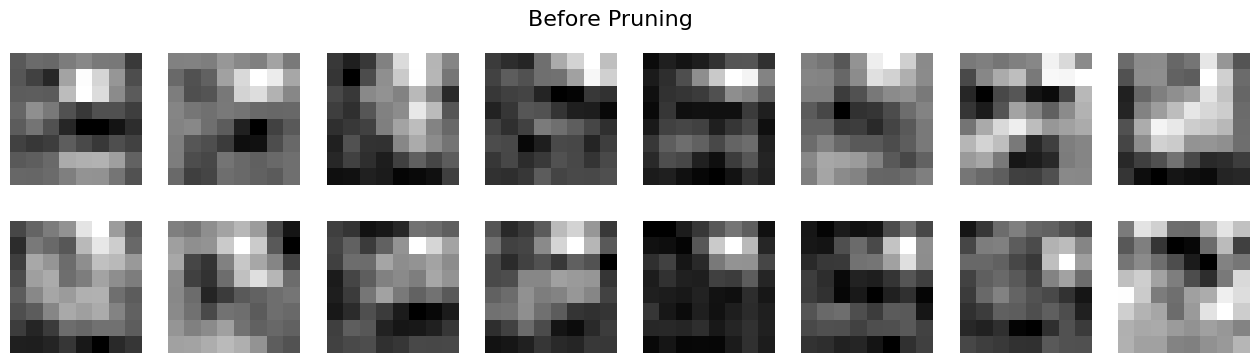

In [29]:
dataiter = iter(testloader)
images, labels = next(dataiter)
sample_img = images[0].unsqueeze(0).cuda()

print("Visualizing 6th Conv Layer Feature Maps BEFORE Pruning:")
visualize_feature_maps(model, sample_img, layer_idx=6, title="Before Pruning")

In [6]:
# Apply Mixed Pruning of 70%
# This will apply 40% structured pruning followed by unstructured pruning to reach ~70% total sparsity.
prune_model(model, amount=0.7, method='mixed')
##### Find "weight_int" for 6th layer ####
w_bit = 4
weight_q = model.features[17].weight_q
w_alpha = model.features[17].weight_quant.wgt_alpha
w_delta = w_alpha /(2**(w_bit-1)-1)

weight_int = weight_q / w_delta
# Show sparsity
sparsity_weight_int = (weight_int == 0).sum() / weight_int.nelement()
print("Sparsity level: ", sparsity_weight_int)

Applying mixed pruning with target amount=0.7...
Global sparsity achieved: 70.00%
Sparsity level:  tensor(0.1940, device='cuda:0')


In [ ]:
lr = 1e-3
weight_decay = 1e-6
epochs = 1000
best_prec = 0
# momentum = 0.9
#model = nn.DataParallel(model).cuda()
model.cuda()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
cudnn.benchmark = True

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=epochs,  # 500
    eta_min=1e-10,  # final LR
)



if not os.path.exists('result'):
    os.makedirs('result')
fdir = 'result/'+str(model_name)
if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):

    train(trainloader, model, criterion, optimizer, epoch)
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    scheduler.step()